#### Gets a quick estimate of the noise level (for initilization of the Gibbs chains), given the image standard deviation.

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../')

from data import GDiff_dataset
from model import load_model
from inference_pytorch.colored_ps import ColoredPS

import inference_pytorch.utils as iut
from utils import get_colored_noise_2d
from sklearn.linear_model import LinearRegression

In [12]:
device = 0

# Target parameters
norm_phi_mode = 'compact' # Normalization mode for phi among ['compact', 'inf', None]
sigma_min, sigma_max = 0.01, 1.0 # Bounds for sigma (no normalization). 0.01 leads to timestep of 1 -> we should not consider lower values with the current model.

# Inference parameters
num_samples = 68

In [13]:
# Load dataset, diffusion model, and power spectrum model
dataset = GDiff_dataset(dataset="CBSD68")
model = load_model(device=device)
ps_model = ColoredPS(norm_input_phi=norm_phi_mode)

In [14]:
#
# Prior, likelihood, and posterior functions
#

sample_phi_prior = lambda n: iut.sample_prior_phi(n, norm=norm_phi_mode, device=device) # Sample uniformly in [-1, 1]

#
# Bounds and collision management
#

phi_min_norm, phi_max_norm = iut.get_phi_bounds(device=device) #change to work in [-1,1]
phi_min_norm, phi_max_norm = iut.normalize_phi(phi_min_norm, mode=norm_phi_mode), iut.normalize_phi(phi_max_norm, mode=norm_phi_mode) #change to work in [-1,1]
sigma_min_tensor = torch.tensor([sigma_min]).to(device)
sigma_max_tensor = torch.tensor([sigma_max]).to(device)
phi_min_norm = torch.concatenate((phi_min_norm, sigma_min_tensor)) # Add sigma_min to the list of parameter bounds
phi_max_norm = torch.concatenate((phi_max_norm, sigma_max_tensor)) # Add sigma_max to the list of parameter bounds


print("Normalized prior bounds are:", phi_min_norm, phi_max_norm)

Normalized prior bounds are: tensor([0.0000, 0.0100], device='cuda:0') tensor([1., 1.], device='cuda:0')


In [15]:
#
# Make test data
#

# Sample phi, sigma, load images, and add noise
phi_true = sample_phi_prior(num_samples)
sigma_true = torch.rand(num_samples, device=device) * (sigma_max - sigma_min) + sigma_min
ps_test = ps_model(phi=phi_true) # power spectrum corresponding to phi_test (taking into account the normalization)
sigma_test_timestep, _ = model.get_closest_timestep(sigma_true, model)
alpha_bar_t = model.alpha_bar_t[sigma_test_timestep.cpu()].reshape(-1, 1, 1, 1).to(device)
x = []
for i in range(num_samples):
    x.append(dataset[i][0].to(device))
x = torch.stack(x)
eps = torch.sqrt(1 - alpha_bar_t)/torch.sqrt(alpha_bar_t)*get_colored_noise_2d((num_samples, 3, 256, 256), phi_true).to(device) # get_colored_noise_2d needs unnormalized parameters
y = x + eps # Noisy image
yt = torch.sqrt(alpha_bar_t) * y # Noisy image normalized for the diffusion model

In [6]:
sigma_true

tensor([0.5797, 0.8285, 0.4446, 0.1864, 0.8518, 0.1656, 0.5245, 0.0667, 0.4159,
        0.0507, 0.7254, 0.8607, 0.5527, 0.0166, 0.7475, 0.3286, 0.4331, 0.4704,
        0.5676, 0.5614, 0.1761, 0.3491, 0.1946, 0.4075, 0.8361, 0.8190, 0.0506,
        0.7226, 0.1432, 0.2756, 0.6619, 0.8150, 0.0127, 0.5217, 0.4155, 0.6029,
        0.5428, 0.6968, 0.9211, 0.4385, 0.8038, 0.2499, 0.2367, 0.7913, 0.3428,
        0.8925, 0.6230, 0.9378, 0.5621, 0.9967, 0.0440, 0.6619, 0.8514, 0.2626,
        0.6328, 0.2006, 0.2255, 0.5139, 0.8447, 0.0674, 0.8391, 0.7102, 0.7672,
        0.0492, 0.2023, 0.3006, 0.1523, 0.3631, 0.8102, 0.5378, 0.8278, 0.1678,
        0.3433, 0.7877, 0.7740, 0.9603, 0.5591, 0.8607, 0.9528, 0.8439, 0.3198,
        0.6174, 0.5049, 0.4107, 0.7251, 0.6496, 0.3008, 0.9287, 0.8728, 0.6730,
        0.3196, 0.8537, 0.0118, 0.5783, 0.3728, 0.1895, 0.0423, 0.9165, 0.9867,
        0.4206], device='cuda:0')

In [16]:
y_std = y.std(dim=(1,2,3))

In [17]:
y = sigma_true.cpu().numpy()
x = y_std.cpu().numpy()

In [18]:
# Make a linear regression of y_std as a function of sigma_true
reg = LinearRegression().fit(x.reshape(-1, 1), y.reshape(-1, 1))
print("R2 score:", reg.score(x.reshape(-1, 1), y.reshape(-1, 1)))
print("Slope:", reg.coef_[0,0])
print("Intercept:", reg.intercept_[0])
print("Slope error:", np.sqrt(np.diag(reg.coef_))[0])
print("Intercept error:", np.sqrt(np.diag(reg.intercept_))[0])

R2 score: 0.9733891801928222
Slope: 1.1539917
Intercept: -0.15453047
Slope error: 1.0742401
Intercept error: [nan]


/tmp/ipykernel_792802/1868530755.py:7: RuntimeWarning: invalid value encountered in sqrt
  print("Intercept error:", np.sqrt(np.diag(reg.intercept_))[0])


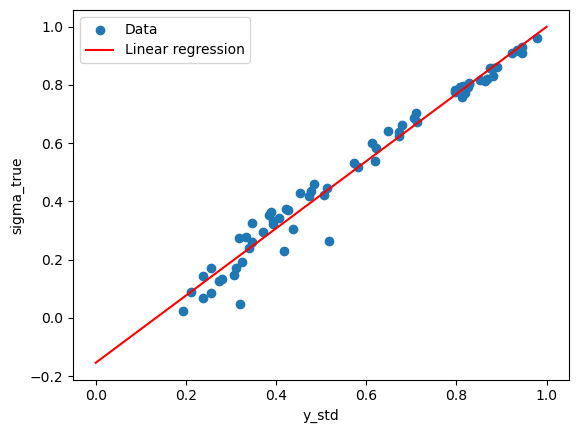

In [19]:
# Plot the results
plt.figure()
plt.scatter(x, y, label="Data")
x_plot = np.linspace(0, 1, 100)
plt.plot(x_plot, reg.predict(x_plot.reshape(-1, 1)), label="Linear regression", color="red")
plt.ylabel("sigma_true")
plt.xlabel("y_std")
plt.legend()

In [24]:
id = 10
print(y_std[id]*1.15 - 0.1545)
print(sigma_true[id])

tensor(0.7794, device='cuda:0')
tensor(0.7592, device='cuda:0')
